In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv -O data.csv

--2023-10-05 21:54:40--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1,41M  --.-KB/s    in 0,1s    

2023-10-05 21:54:40 (11,1 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('data.csv')

df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
col = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]

df = df[col]

In [5]:
names = dict(
    (c, c.lower().replace(' ', '_')) for c in col
)

df = df.rename(columns=names)

df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [6]:
df = df.fillna(0)

In [7]:
mean_msrp = df.msrp.mean()

df['above_average'] = df.apply(lambda row: 1 if row.msrp > mean_msrp else 0 , axis=1)

In [8]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [9]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.6, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

In [10]:
len(df_train), len(df_val), len(df_test)

(4765, 3574, 3575)

# Q1

In [11]:
import numpy as np
def auc_sim(pos, neg):
    n = 50000

    np.random.seed(1)
    pos_ind = np.random.randint(0, len(pos), size=n)
    neg_ind = np.random.randint(0, len(neg), size=n)

    auc = (pos[pos_ind] > neg[neg_ind]).mean()
    if auc < 0.5:
        return (-pos[pos_ind] > -neg[neg_ind]).mean()
    return auc

In [12]:
numerical_col = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

for col in numerical_col:
    pos = df_train[col][df_train.above_average == 1].values
    neg = df_train[col][df_train.above_average == 0].values
    
    print(f'{col} - AUC {auc_sim(pos, neg)}')

engine_hp - AUC 0.91128
engine_cylinders - AUC 0.64102
highway_mpg - AUC 0.6026
city_mpg - AUC 0.63612


# Q2

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

cat_columns = ['make', 'model', 'transmission_type', 'vehicle_style']

dv = DictVectorizer(sparse=False).fit(df_train[cat_columns].to_dict('records'))
clf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

def transform(df):
    
    y = df['above_average'].values
    X_num = df[numerical_col].values
    X_cat = dv.transform(df[cat_columns].to_dict('records'))
    assert (X_cat.sum(axis=1) == 0).sum() == 0, 'axis all zero'
    X = np.concatenate((X_num, X_cat), axis=1)
    
    return X, y



    
X_train, y_train = transform(df_train)
X_val, y_val = transform(df_val)


clf = clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

0.9804745551194604

# Q3

In [15]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.arange(0, 1 + 0.01, 0.01)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1_score'] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)
    
    return df_scores

In [16]:
df_clf = tpr_fpr_dataframe(y_val, y_pred)

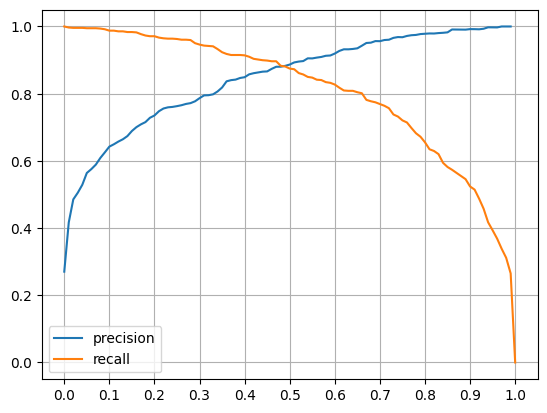

In [17]:
import matplotlib.pyplot as plt
plt.plot(df_clf.threshold, df_clf['precision'], label='precision')
plt.plot(df_clf.threshold, df_clf['recall'], label='recall')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.legend()

# Q4

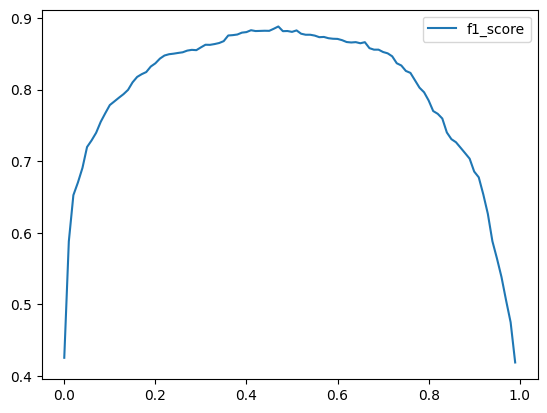

In [18]:
plt.plot(df_clf.threshold, df_clf['f1_score'], label='f1_score')
plt.legend()

In [19]:
idx = df_clf['f1_score'].argmax()
df_clf.threshold[idx]

0.47000000000000003

# Q5

In [20]:
from sklearn.model_selection import KFold

def kfold(C):

    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    auc = []
    for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        _X_train = X_train[train_index]
        _y_train = y_train[train_index]

        clf = LogisticRegression(solver='liblinear', C=C, max_iter=1000).fit(_X_train, _y_train)

        _X_val = X_train[val_index]
        _y_val = y_train[val_index]

        y_pred_1 = clf.predict_proba(_X_val)[:, 1]
        y_pred_0 = clf.predict_proba(_X_val)[:, 0]

        auc.append(max(roc_auc_score(_y_val, y_pred_1), roc_auc_score(_y_val, y_pred_0)))
    
    return np.mean(auc).round(3), np.std(auc).round(3)

kfold(1.0)

(0.98, 0.003)

# Q6

In [21]:
C = [0.01, 0.1, 0.5, 10]

for c in C:
    print(c, '- AUC -', kfold(c))

0.01 - AUC - (0.923, 0.009)
0.1 - AUC - (0.964, 0.003)
0.5 - AUC - (0.977, 0.004)
10 - AUC - (0.983, 0.003)
